In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np

#TO DO: 코호트간 어떤 차이점이 있는지 살펴본다

users = pd.read_csv('users.csv')
claims = pd.read_csv('dutchpay_claim.csv')
detail = pd.read_csv('dutchpay_claim_detail.csv')

In [2]:
#claim_at을 datetime으로 변환, 최초 claim_at 시점 기준으로 cohort 정보 추가
claims['claim_at'] = pd.to_datetime(claims['claim_at'])
claims['claim_date'] = claims['claim_at'].dt.to_period('D')
claims['claim_month'] = claims['claim_at'].dt.to_period('M')
claims['cohort'] = claims.groupby('claim_user_id')['claim_at'].transform('min').dt.to_period('M')
claims = claims.rename(columns={'claim_user_id': 'user_id'})
claims.head(10)

,claim_id,claim_at,user_id,claim_date,claim_month,cohort
0,4420721,2020-02-07 15:29:18,5cbd74112c55a0a,2020-02-07,2020-02,2020-02
1,4420704,2020-02-07 15:26:54,5cbd74112c55a0a,2020-02-07,2020-02,2020-02
2,4454342,2020-02-10 19:18:31,f077bc4ec8fd0ef,2020-02-10,2020-02,2020-01
3,4453683,2020-02-10 18:15:11,f077bc4ec8fd0ef,2020-02-10,2020-02,2020-01
4,4348820,2020-02-01 09:41:30,f077bc4ec8fd0ef,2020-02-01,2020-02,2020-01
5,4209764,2020-01-18 23:26:22,f077bc4ec8fd0ef,2020-01-18,2020-01,2020-01
6,4029623,2020-01-02 08:23:09,f077bc4ec8fd0ef,2020-01-02,2020-01,2020-01
7,4443213,2020-02-09 15:26:52,bc4e6d194bb1ffe,2020-02-09,2020-02,2020-02
8,4687848,2020-02-29 14:10:39,f6546c3de672d9e,2020-02-29,2020-02,2019-12
9,4680499,2020-02-29 19:34:13,f6546c3de672d9e,2020-02-29,2020-02,2019-12


In [3]:
#cohort를 user_id와 엮어서 정리
cohort_info = claims[['user_id','cohort']].drop_duplicates()
cohort_info.head()

,user_id,cohort
0,5cbd74112c55a0a,2020-02
2,f077bc4ec8fd0ef,2020-01
7,bc4e6d194bb1ffe,2020-02
8,f6546c3de672d9e,2019-12
13,40309303ce7fec1,2019-12


In [4]:
#cohort 정보랑 연령대 column 추가
users['age_group'] = (np.floor(users['age']/10)*10).astype(int)
user_cohorts = pd.merge(users, cohort_info, how='left', on='user_id')
user_cohorts.head(10)

,user_id,gender_cd,age,foreigner_yn,os_type,age_group,cohort
0,01509a0865440e0,2,32,N,A,30,2019-12
1,7d4697fbadb1c09,1,27,N,A,20,NaT
2,7b2a7724faf1400,1,26,N,A,20,NaT
3,b3876137175bec2,1,25,N,B,20,2019-12
4,4e1d1005ebb3119,2,31,N,A,30,NaT
5,a81f26d3c612a1e,2,29,N,A,20,NaT
6,aa591e4c05aa100,2,37,N,A,30,2020-02
7,8017adb2b9f959d,2,36,N,A,30,NaT
8,25c5050fb7b24dc,1,28,N,A,20,2020-02
9,2d24f87ab27f37e,2,30,N,A,30,NaT


In [5]:
#cohort x 연령대 pivot table
user_pivot = pd.pivot_table(user_cohorts, values='user_id', index=['age_group'], columns=['cohort'], aggfunc=lambda x: len(x.unique()))
user_pivot

cohort,2019-12,2020-01,2020-02
age_group,,,
10,612,479,397
20,15373,9529,7950
30,6823,4281,3489
40,1785,1251,973
50,267,187,162


In [6]:
#월별로 모든 연령대에서 유저수가 줄고 있음
user_pivot.pct_change(axis='columns')

cohort,2019-12,2020-01,2020-02
age_group,,,
10,NaN,-0.217320,-0.171190
20,NaN,-0.380147,-0.165705
30,NaN,-0.372563,-0.185004
40,NaN,-0.299160,-0.222222
50,NaN,-0.299625,-0.133690


In [7]:
#2개월간 차이
user_pivot.pct_change(axis='columns', periods=2)

cohort,2019-12,2020-01,2020-02
age_group,,,
10,NaN,NaN,-0.351307
20,NaN,NaN,-0.482860
30,NaN,NaN,-0.488641
40,NaN,NaN,-0.454902
50,NaN,NaN,-0.393258


In [8]:
#성별로도 나눠서 pivot table
gender_age = pd.pivot_table(user_cohorts, values='user_id', index=['gender_cd','age_group'], columns=['cohort'], aggfunc=lambda x: len(x.unique()))
gender_age

cohort               2019-12  2020-01  2020-02
gender_cd age_group                           
1         10             350      285      237
          20            9277     5631     4711
          30            3933     2482     2023
          40            1152      803      598
          50             157      115      105
2         10             262      194      160
          20            6096     3898     3239
          30            2890     1799     1466
          40             633      448      375
          50             110       72       57

In [9]:
#어찌 됐든 성별과 상관없이 20대, 30대 사용자들 감소 폭이 제일 심각함
gender_age.pct_change(axis='columns')

cohort               2019-12   2020-01   2020-02
gender_cd age_group                             
1         10             NaN -0.185714 -0.168421
          20             NaN -0.393015 -0.163381
          30             NaN -0.368930 -0.184932
          40             NaN -0.302951 -0.255293
          50             NaN -0.267516 -0.086957
2         10             NaN -0.259542 -0.175258
          20             NaN -0.360564 -0.169061
          30             NaN -0.377509 -0.185103
          40             NaN -0.292259 -0.162946
          50             NaN -0.345455 -0.208333

In [10]:
#성별, OS별 구성비율 조사
gender_os = pd.pivot_table(user_cohorts, values='user_id', index=['gender_cd', 'os_type'], columns=['cohort'], aggfunc=lambda x: len(x.unique()))
gender_os

cohort             2019-12  2020-01  2020-02
gender_cd os_type                           
1         A           6107     3935     3133
          B           8762     5381     4541
2         A           6203     3989     3242
          B           3788     2422     2055

In [11]:
#각 코호트 마다 성별 1 유저들 중에는 OS B 사용비중이, 성별 2 유저들 중에는 OS A 사용비중이 높음을 볼 수 있음: 코호트간 특별한 차이 없음
gender_os.divide(gender_os.sum(), axis=1)

cohort              2019-12   2020-01   2020-02
gender_cd os_type                              
1         A        0.245656  0.250207  0.241539
          B        0.352454  0.342150  0.350089
2         A        0.249517  0.253640  0.249942
          B        0.152373  0.154003  0.158430

In [12]:
gender_os.pct_change(axis='columns')

cohort             2019-12   2020-01   2020-02
gender_cd os_type                             
1         A            NaN -0.355657 -0.203812
          B            NaN -0.385871 -0.156105
2         A            NaN -0.356924 -0.187265
          B            NaN -0.360612 -0.151528

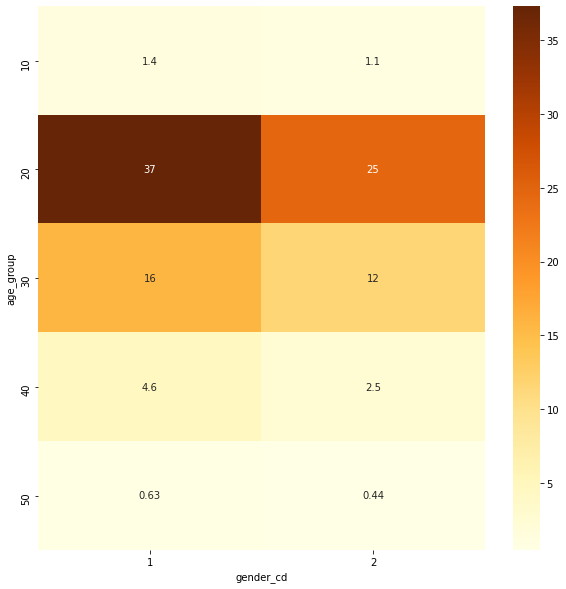

In [13]:
#2019-12 코호트의 성별, 연령대별 비중을 알아보자
december = pd.pivot_table(user_cohorts[user_cohorts['cohort']=='2019-12'], values='user_id', index=['age_group'], columns=['gender_cd'], aggfunc=lambda x: len(x.unique()))
december_pct = (100.0*december/(user_cohorts[user_cohorts['cohort']=='2019-12'].user_id.nunique())).round(2)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(december_pct, annot=True, cmap="YlOrBr")

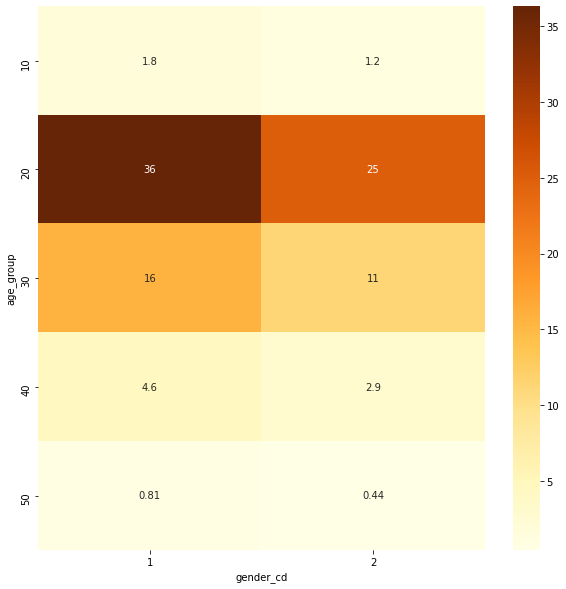

In [14]:
#2020-02 코호트와 비교: 비슷하다...
february = pd.pivot_table(user_cohorts[user_cohorts['cohort']=='2020-02'], values='user_id', index=['age_group'], columns=['gender_cd'], aggfunc=lambda x: len(x.unique()))
february_pct = (100.0*february/(user_cohorts[user_cohorts['cohort']=='2020-02'].user_id.nunique())).round(2)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(february_pct, annot=True, cmap="YlOrBr")

In [15]:
#user demography 외 거래 관련 데이터로도 코호트를 비교해보자:
#각 claim별 요청 받은 유저수, 응답률, 총 요청 금액도 정리
receiver_count = detail.groupby('claim_id').recv_user_id.nunique()
success_count = detail[detail['status']!='CLAIM'].groupby('claim_id').recv_user_id.nunique()
success_rate = 100.0*success_count/receiver_count
total_amount = detail.groupby('claim_id').agg({'claim_amount': 'sum'})

In [16]:
claim_summary = pd.concat([receiver_count, success_count, success_rate, total_amount], axis=1)
claim_summary.columns = ['receiver_count', 'success_count', 'success_rate', 'total_amount']
claim_summary.head()

,receiver_count,success_count,success_rate,total_amount
claim_id,,,,
3710950,3,1.0,33.333333,25998
3710962,3,3.0,100.000000,21000
3710963,1,1.0,100.000000,1530
3710972,5,1.0,20.000000,49500
3710973,5,1.0,20.000000,72000


In [17]:
#기존 claims 데이터와 합침
claims = pd.merge(claims, claim_summary, how='left', on='claim_id')
claims.head()

,claim_id,claim_at,user_id,claim_date,claim_month,cohort,receiver_count,success_count,success_rate,total_amount
0,4420721,2020-02-07 15:29:18,5cbd74112c55a0a,2020-02-07,2020-02,2020-02,4.0,2.0,50.000000,52000.0
1,4420704,2020-02-07 15:26:54,5cbd74112c55a0a,2020-02-07,2020-02,2020-02,6.0,1.0,16.666667,78996.0
2,4454342,2020-02-10 19:18:31,f077bc4ec8fd0ef,2020-02-10,2020-02,2020-01,5.0,5.0,100.000000,64000.0
3,4453683,2020-02-10 18:15:11,f077bc4ec8fd0ef,2020-02-10,2020-02,2020-01,8.0,7.0,87.500000,160000.0
4,4348820,2020-02-01 09:41:30,f077bc4ec8fd0ef,2020-02-01,2020-02,2020-01,4.0,1.0,25.000000,36300.0


In [18]:
#요청자 데이터까지 포함한 종합 테이블 생성
comp = pd.merge(claims, users, how='left', on='user_id')
comp.head()

,claim_id,claim_at,user_id,claim_date,claim_month,cohort,receiver_count,success_count,success_rate,total_amount,gender_cd,age,foreigner_yn,os_type,age_group
0,4420721,2020-02-07 15:29:18,5cbd74112c55a0a,2020-02-07,2020-02,2020-02,4.0,2.0,50.000000,52000.0,1,28,N,A,20
1,4420704,2020-02-07 15:26:54,5cbd74112c55a0a,2020-02-07,2020-02,2020-02,6.0,1.0,16.666667,78996.0,1,28,N,A,20
2,4454342,2020-02-10 19:18:31,f077bc4ec8fd0ef,2020-02-10,2020-02,2020-01,5.0,5.0,100.000000,64000.0,1,28,N,B,20
3,4453683,2020-02-10 18:15:11,f077bc4ec8fd0ef,2020-02-10,2020-02,2020-01,8.0,7.0,87.500000,160000.0,1,28,N,B,20
4,4348820,2020-02-01 09:41:30,f077bc4ec8fd0ef,2020-02-01,2020-02,2020-01,4.0,1.0,25.000000,36300.0,1,28,N,B,20


In [19]:
#월별 데이터 정리
monthly_users = comp.groupby('claim_month').user_id.nunique()
monthly_claims = comp.groupby('claim_month').claim_id.nunique()
monthly_amount = comp.groupby('claim_month').agg({'total_amount': 'sum'})
monthly_receivers = comp.groupby('claim_month').agg({'receiver_count': 'mean'})
monthly_success = comp.groupby('claim_month').agg({'success_rate': 'mean'})
monthly = pd.concat([monthly_users, monthly_claims, monthly_amount, monthly_receivers, monthly_success], axis=1)
monthly.columns = ['monthly_users', 'monthly_claims', 'monthly_amount','monthly_receivers','monthly_success']
monthly.head()
#혹시나 해서 추가했지만, 월별 평균 더치페이 요청 수신자랑 평균 요청 응답률에서는 생각보다 유의미한 차이는 없는 듯

,monthly_users,monthly_claims,monthly_amount,monthly_receivers,monthly_success
claim_month,,,,,
2019-12,24860,49886,6.165083e+09,3.516236,59.248229
2020-01,25825,53501,5.976270e+09,3.464126,59.955628
2020-02,26869,55807,5.886204e+09,3.537027,59.235873


In [20]:
monthly['avg_claims_per_user'] = monthly['monthly_claims']/monthly['monthly_users']
monthly['avg_amount_per_claim'] = monthly['monthly_amount']/monthly['monthly_claims']
monthly.head()

,monthly_users,monthly_claims,monthly_amount,monthly_receivers,monthly_success,avg_claims_per_user,avg_amount_per_claim
claim_month,,,,,,,
2019-12,24860,49886,6.165083e+09,3.516236,59.248229,2.006677,123583.437918
2020-01,25825,53501,5.976270e+09,3.464126,59.955628,2.071675,111703.894039
2020-02,26869,55807,5.886204e+09,3.537027,59.235873,2.077003,105474.301306


In [21]:
#월별 수치 변화
monthly.pct_change()

,monthly_users,monthly_claims,monthly_amount,monthly_receivers,monthly_success,avg_claims_per_user,avg_amount_per_claim
claim_month,,,,,,,
2019-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01,0.038817,0.072465,-0.030626,-0.014820,0.011940,0.032391,-0.096126
2020-02,0.040426,0.043102,-0.015071,0.021045,-0.012005,0.002572,-0.055769


In [22]:
monthly.pct_change(periods=2)

,monthly_users,monthly_claims,monthly_amount,monthly_receivers,monthly_success,avg_claims_per_user,avg_amount_per_claim
claim_month,,,,,,,
2019-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02,0.080813,0.118691,-0.045235,0.005913,-0.000209,0.035046,-0.146534


In [23]:
#각 코호트의 첫 사용월내에 발생한 데이터 정리
user_count = comp[comp['cohort']==comp['claim_month']].groupby('cohort').user_id.nunique()
claim_count = comp[comp['cohort']==comp['claim_month']].groupby('cohort').claim_id.nunique()
total_amount = comp[comp['cohort']==comp['claim_month']].groupby('cohort').agg({'total_amount': 'sum'})
avg_receivers = comp[comp['cohort']==comp['claim_month']].groupby('cohort').agg({'receiver_count': 'mean'})
avg_success = comp[comp['cohort']==comp['claim_month']].groupby('cohort').agg({'success_rate': 'mean'})
cohort_data_1m = pd.concat([user_count, claim_count, total_amount, avg_receivers, avg_success], axis=1)
cohort_data_1m.columns = ['user_count', 'claim_count', 'total_amount','avg_receivers','avg_success']
cohort_data_1m

,user_count,claim_count,total_amount,avg_receivers,avg_success
cohort,,,,,
2019-12,24860,49886,6.165083e+09,3.516236,59.248229
2020-01,15727,24348,3.816943e+09,3.494802,57.333876
2020-02,12971,19172,3.183829e+09,3.611649,55.366610


In [24]:
cohort_data_1m['avg_claims'] = cohort_data_1m['claim_count']/cohort_data_1m['user_count']
cohort_data_1m['avg_amount_per_claim'] = cohort_data_1m['total_amount']/cohort_data_1m['claim_count']
cohort_data_1m['avg_amount_per_user'] = cohort_data_1m['total_amount']/cohort_data_1m['user_count']
cohort_data_1m

,user_count,claim_count,total_amount,avg_receivers,avg_success,avg_claims,avg_amount_per_claim,avg_amount_per_user
cohort,,,,,,,,
2019-12,24860,49886,6.165083e+09,3.516236,59.248229,2.006677,123583.437918,247992.091070
2020-01,15727,24348,3.816943e+09,3.494802,57.333876,1.548166,156766.170774,242699.988936
2020-02,12971,19172,3.183829e+09,3.611649,55.366610,1.478066,166066.602076,245457.473980


In [25]:
cohort_data_1m.pct_change()

,user_count,claim_count,total_amount,avg_receivers,avg_success,avg_claims,avg_amount_per_claim,avg_amount_per_user
cohort,,,,,,,,
2019-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01,-0.367377,-0.511927,-0.380877,-0.006096,-0.032311,-0.228493,0.268505,-0.021340
2020-02,-0.175240,-0.212584,-0.165869,0.033435,-0.034312,-0.045279,0.059327,0.011362


In [26]:
#신규 사용자 하락에 대한 돌파구를 찾아보자:
#유저 DB에 있는 유저들 중 아직 더치페이를 경험하지 않은 유저들은 얼마나 있을까?
user_cohorts.info()
#123924명의 유저 중 53558명만 코호트에 속한다 = 43.22%

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123924 entries, 0 to 123923
Data columns (total 7 columns):
user_id         123924 non-null object
gender_cd       123924 non-null int64
age             123924 non-null int64
foreigner_yn    123924 non-null object
os_type         123924 non-null object
age_group       123924 non-null int64
cohort          53558 non-null period[M]
dtypes: int64(3), object(3), period[M](1)
memory usage: 7.6+ MB


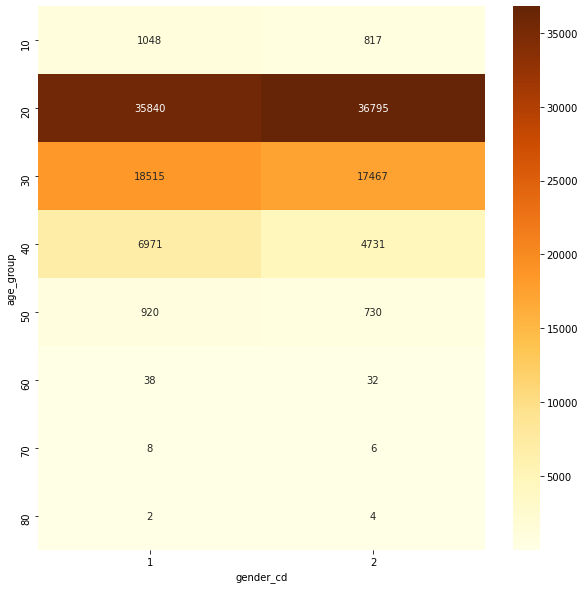

In [27]:
#users 테이블에 존재하는 모든 사용자 수를 성별, 연령대별로 집계
user_pivot = pd.pivot_table(user_cohorts, values='user_id', index=['age_group'], columns=['gender_cd'], aggfunc=lambda x: len(x.unique()))
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(user_pivot, annot=True, fmt='d', cmap='YlOrBr')

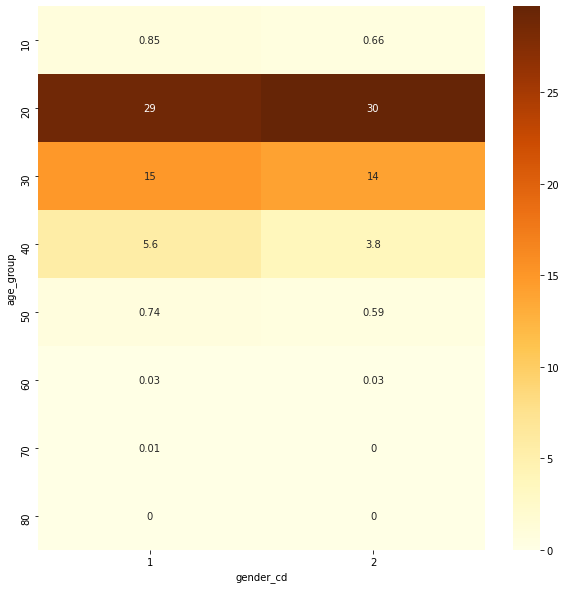

In [28]:
#percentage로 표현
user_percentage = (100.0*user_pivot/(user_cohorts.user_id.nunique())).round(2)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(user_percentage, annot=True, cmap='YlOrBr')
#위에서 두 코호트를 봤을 때는 20대 유저 중 gender 1이 gender 2보다 비중이 높았는데
#DB에 있는 모든 유저를 봤을 때는 안그렇다: user demography 별로 활성비율이 다를까?

In [29]:
#연령대별로 회원가입한 유저 수 대비 더치페이 사용 (요청) 이력이 있는 유저, 없는 유저 비중을 코호트별로 나눔
all_users = user_cohorts.groupby(['age_group']).user_id.nunique()
dec_users = user_cohorts[user_cohorts['cohort']=='2019-12'].groupby(['age_group']).user_id.nunique()
jan_users = user_cohorts[user_cohorts['cohort']=='2020-01'].groupby(['age_group']).user_id.nunique()
feb_users = user_cohorts[user_cohorts['cohort']=='2020-02'].groupby(['age_group']).user_id.nunique()

activation_age = pd.concat([all_users, 100.0*dec_users/all_users, 100.0*jan_users/all_users, 100.0*feb_users/all_users, 100.0*(all_users-dec_users-jan_users-feb_users)/all_users], axis=1)
activation_age.columns = ['all_users', 'dec_rate', 'jan_rate', 'feb_rate', 'inactive_rate']
activation_age
#회원가입을 했다고 꼭 더치페이를 사용한 건 아니다: 잠재적 더치페이 사용자들이 아직 많이 남아있다
#연령대별로 높으면 66%, 낮으면 20%

,all_users,dec_rate,jan_rate,feb_rate,inactive_rate
age_group,,,,,
10,1865,32.815013,25.683646,21.286863,20.214477
20,72635,21.164728,13.119020,10.945137,54.771116
30,35982,18.962259,11.897615,9.696515,59.443611
40,11702,15.253803,10.690480,8.314818,65.740899
50,1650,16.181818,11.333333,9.818182,62.666667
60,70,NaN,NaN,NaN,NaN
70,14,NaN,NaN,NaN,NaN
80,6,NaN,NaN,NaN,NaN


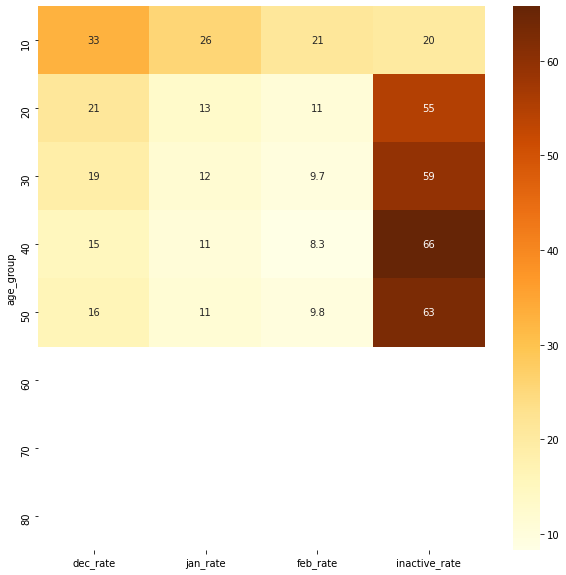

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(activation_age.loc[:, activation_age.columns != 'all_users'], annot=True, cmap='YlOrBr')

In [31]:
#위와 같은 걸 성별로 정리
all_gender = user_cohorts.groupby(['gender_cd']).user_id.nunique()
dec_gender = user_cohorts[user_cohorts['cohort']=='2019-12'].groupby(['gender_cd']).user_id.nunique()
jan_gender = user_cohorts[user_cohorts['cohort']=='2020-01'].groupby(['gender_cd']).user_id.nunique()
feb_gender = user_cohorts[user_cohorts['cohort']=='2020-02'].groupby(['gender_cd']).user_id.nunique()

activation_gender = pd.concat([all_gender, 100.0*dec_gender/all_gender, 100.0*jan_gender/all_gender, 100.0*feb_gender/all_gender, 100.0*(all_gender-dec_gender-jan_gender-feb_gender)/all_gender], axis=1)
activation_gender.columns = ['all_users', 'dec_rate', 'jan_rate', 'feb_rate', 'inactive_rate']
activation_gender

,all_users,dec_rate,jan_rate,feb_rate,inactive_rate
gender_cd,,,,,
1,63342,23.474156,14.707461,12.115184,49.703199
2,60582,16.491697,10.582351,8.743521,64.182430


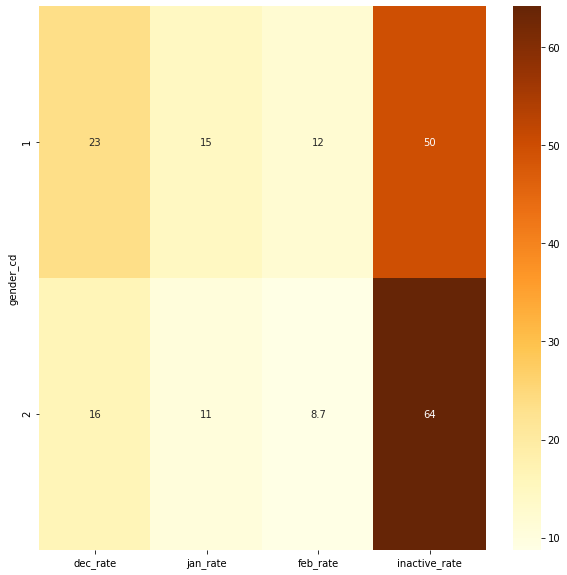

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(activation_gender.loc[:, activation_gender.columns != 'all_users'], annot=True, cmap='YlOrBr')